In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import seaborn as sns
import theano.tensor as tt

/Users/peadarcoyle/miniconda3/envs/stat-rethink-pymc3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Hierachical models - and why should I care?
It's worth spending some time exploring and explaining what Hierachical models are.

Hierarchical or multilevel modeling is a generalization of regression modeling.

*Multilevel models* are regression models in which the constituent model parameters are given **probability models**. This implies that model parameters are allowed to **vary by group**.

Observational units are often naturally **clustered**. Clustering induces dependence between observations, despite random sampling of clusters and random sampling within clusters.

A *hierarchical model* is a particular multilevel model where parameters are nested within one another.

Some multilevel structures are not hierarchical. 
- e.g. "country" and "year" are not nested, but may represent separate, but overlapping, clusters of parameters

Some applications in industry
- There are natural applications of multilevel models in say e-commerce. A garment may be both luxury *and* for females *and* a certain range of prices. 
- In advertising you may have various interest groups *and* age groups. 
- In financial products you may have various risk groups. Loans may be high risk, low risk, etc. 

# Are you convinced self-driving cars are safe?

A friend posed the following question: 

"In MA there were 0.52 fatalities/100 million miles driven. Since 2009 Google has driven ~1.5 million miles without a crash - does this convince you that self-driving cars are safe?"

I objected to the premise for a number of reasons:

- We're comparing a rate (0.52 fatalities/100mm) to a number (0 fatalities)
- Google probably drives in California, not Massachusetts

In searching for the California fatality rate, I found a beautiful data set that allowed me to essentially copy and paste the case study for hierarchical partial pooling from the <a href="http://docs.pymc.io/notebooks/hierarchical_partial_pooling.html">PyMC3 documentation</a> and the <a href="http://mc-stan.org/users/documentation/case-studies/pool-binary-trials.html">Stan documentation</a>.  That study was estimating batting averages early in the season, and pooling over different players.  We will pool our data over the states, and change the response from a `Binomial` distribution (did the batter hit?) to a `Poisson` distribution (how many fatalities occured during the period?)



## Approach
We will use PyMC3 to estimate the number of fatalities for each state and Google/Uber. Having estimated the number of fatalities across all states in the datasets, we can use this information to inform an estimate of google, for which there is little data (i.e. 4 million miles).

In the absence of a Bayesian hierarchical model, there are two approaches for this problem:

- independently compute number of fatalities for each state (no pooling)
- compute an overall average number of fatalaties, under the assumption that everyone has the same underlying average number of fatalities (complete pooling)

Of course, neither approach is realistic. Clearly, all states aren’t equally dangerous, so the global average number of fatalities is implausible. At the same time, there are underlying similarities, across all states, due to human behaviour being similar.

It may be possible to cluster groups of “similar” states, and estimate group fatalities, but using a hierarchical modeling approach is a natural way of sharing information that does not involve identifying ad hoc clusters.

The idea of hierarchical partial pooling is to model the global performance, and use that estimate to parameterize a population of states that accounts for differences among the states’ safety performance. This tradeoff between global and individual performance will be automatically tuned by the model. Also, uncertainty due to different number of miles for each state (i.e. information) will be automatically accounted for, by shrinking those estimates closer to the global mean.

# Gathering Data

There's a page with a beautiful table, and a beautiful html reader in pandas, so this works.

In [3]:
import os
fatality_data = 'fatality_data.csv'

In [4]:
if not os.path.exists(fatality_data):
    df = pd.read_html('https://www.fhwa.dot.gov/ohim/onh00/onh2p11.htm')[0]
    df.columns = df.iloc[0]
    df = df.reindex(df.index.drop([0, 52]))  # also drop the aggregate row
    df.to_csv(fatality_data, index=False)
df = pd.read_csv(fatality_data)

In [5]:
# Pandas did not detect most columns as numeric, so we can cast them all here
df[df.columns[1:]] = df[df.columns[1:]].apply(pd.to_numeric)

# Extract the data we need as numpy arrays
miles_e6 = (df['Annual VMT (Millions)']).as_matrix()
fatalities = df['Total Highway Fatalities'].as_matrix()

In [6]:
df.describe()

Resident Population  Driving Age Population  \
count            51.000000               51.000000   
mean           5517.627451             4256.960784   
std            6164.031223             4710.246333   
min             493.000000              382.000000   
25%            1502.000000             1162.500000   
50%            4012.000000             3115.000000   
75%            6214.500000             4845.000000   
max           33871.000000            25599.000000   

       Highway Motor Fuel Use (000)  Total Lane Miles  \
count                  5.100000e+01         51.000000   
mean                   3.181572e+06     161242.862745   
std                    3.203077e+06     111899.427793   
min                    1.924400e+05       3774.000000   
25%                    9.696665e+05      77417.000000   
50%                    2.478132e+06     164231.000000   
75%                    4.174523e+06     232815.000000   
max                    1.701762e+07     639853.000000   

       Total Road and Street Mileage  Annual VMT (Millions)  \
count                      51.000000              51.000000   
mean                    77180.960784           53917.705882   
std                     52950.701275           56101.220202   
min                      1425.000000            3498.000000   
25%                     36649.500000           15914.500000   
50%                     79267.000000           41771.000000   
75%                    112708.500000           67264.500000   
max                    301035.000000          306649.000000   

       Total Highway Fatalities  Fatalities (per 100 million VMT)  \
count                 51.000000                         51.000000   
mean                 820.019608                          1.590980   
std                  819.095171                          0.425433   
min                   49.000000                          0.820000   
25%                  276.000000                          1.225000   
50%                  632.000000                          1.510000   
75%                 1050.500000                          1.885000   
max                 3769.000000                          2.670000   

       State Motor Fuel Taxes and Other Related Receipts  \
count                                       5.100000e+01   
mean                                        6.170644e+05   
std                                         6.074296e+05   
min                                         2.781700e+04   
25%                                         2.208780e+05   
50%                                         4.397850e+05   
75%                                         7.358900e+05   
max                                         2.945156e+06   

       Total Highway Capital Outlay (000)  \
count                        5.100000e+01   
mean                         9.336550e+05   
std                          7.903584e+05   
min                          1.295270e+05   
25%                          3.520100e+05   
50%                          6.973580e+05   
75%                          1.092262e+06   
max                          3.421427e+06   

       Total Disburse-ments for Highways (000)  Payments the HTF (000)  \
count                             5.100000e+01            5.100000e+01   
mean                              1.761430e+06            5.950433e+05   
std                               1.527280e+06            5.864202e+05   
min                               2.442160e+05            3.372800e+04   
25%                               6.228125e+05            1.969735e+05   
50%                               1.304378e+06            4.286790e+05   
75%                               1.986232e+06            7.636140e+05   
max                               6.750225e+06            3.025732e+06   

       Apportion-ments from the Federal HTF (000)  
count                                5.100000e+01  
mean                                 5.871697e+05  
std                                  5.185443e

# Build a hierarchical model

We assume that there is a distribution of fatality rates, and each state has a background rate drawn from there.  We really should model state-level effects more carefully before applying this pooling, but life is short.  We additionally assume that google's cars have a fatality rate drawn from the same distribution.  This is a prior we could argue over, but it seems reasonable, given our lack of other experiments with self driving cars.

Intuitively, $\phi$ is the probability of probabilities, and $\theta$ is a vector of length 51 (DC is a state?), with estimates for their own true fatality rates.  I model google's and Ubers self-driving fatality rate as a separate variable, but in the same way, as $\theta_{\text{google}}$ and $\theta_{\text{uber}}$.

For what it is worth, I used the *exact* model from the PyMC3 documentation (with `y` being Binomial distributed instead of Poisson), and came to qualitatively the same conclusions.

We'll start with assuming that uber miles are 1.0 million miles and fatalities are 1.0

In [9]:
def car_model(miles, fatalities, google_miles=1.5, google_fatalities=0, uber_miles=1.0, 
              uber_fatalities=1):
    with pm.Model() as model:
        pooled_rate = pm.Uniform('pooled_rate', lower=0.0, upper=1.0)
        κ_log = pm.Exponential('κ_log', lam=1.5)
        κ = pm.Deterministic('κ', tt.exp(κ_log))

        state_rate = pm.Beta('state_rate', 
                             alpha=pooled_rate*κ, 
                             beta=(1.0-pooled_rate)*κ, 
                             shape=len(fatalities))
        observed_fatalities = pm.Poisson('y', mu=state_rate*miles, observed=fatalities)

        google_rate = pm.Beta('google_rate', 
                              alpha=pooled_rate*κ, 
                              beta=(1.0-pooled_rate)*κ)
        observed_google_fatalities = pm.Poisson('y_new', 
                                                mu=google_miles*google_rate, 
                                                observed=google_fatalities)
        uber_rate = pm.Beta('uber_rate', 
                              alpha=pooled_rate*κ, 
                              beta=(1.0-pooled_rate)*κ)
        observed_uber_fatalities = pm.Poisson('y_new_uber', 
                                                mu=uber_miles*uber_rate, 
                                                observed=uber_fatalities)
    return model

In [10]:
with car_model(miles_e6, fatalities):
    trace = pm.sample(10000, tune=500, njobs=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [uber_rate, google_rate, state_rate, κ_log, pooled_rate]
100%|██████████| 10500/10500 [00:26<00:00, 393.27it/s]


# Interpreting the model

We drew four chains, and the chains look pretty identical, so seems like a good trace.

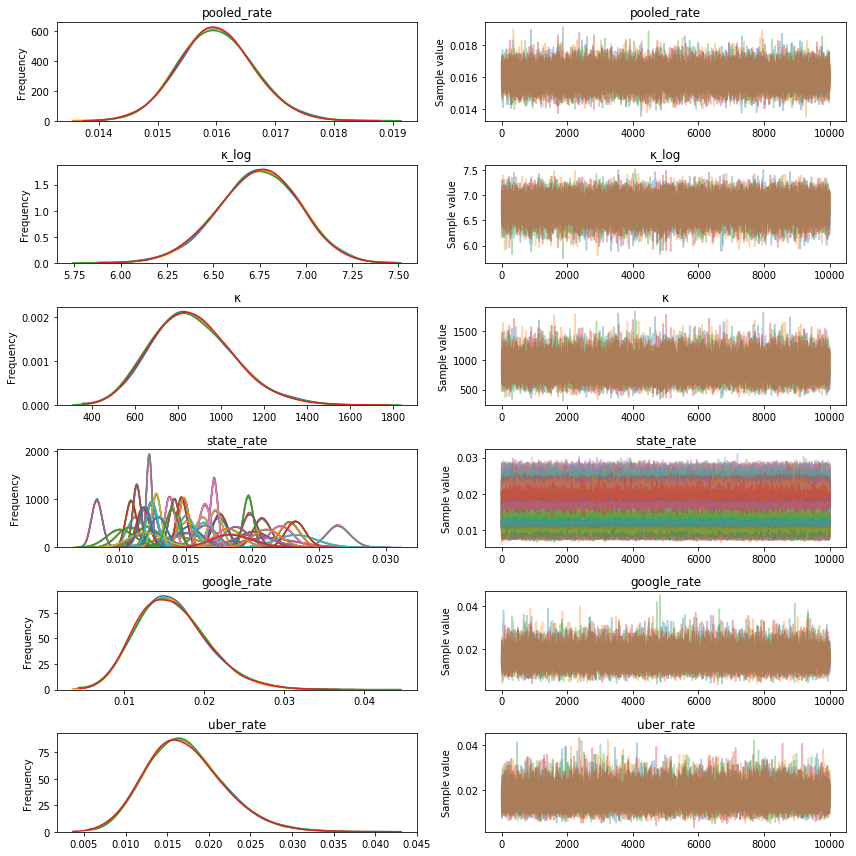

In [11]:
pm.traceplot(trace);

# Answering the question

The original question was whether I trust Google's self driving cars, given the fatality rate in MA.  I don't, yet. 

We've added in Uber's cars to have a comparison too. 

In [12]:
plt.style.use('seaborn-talk')

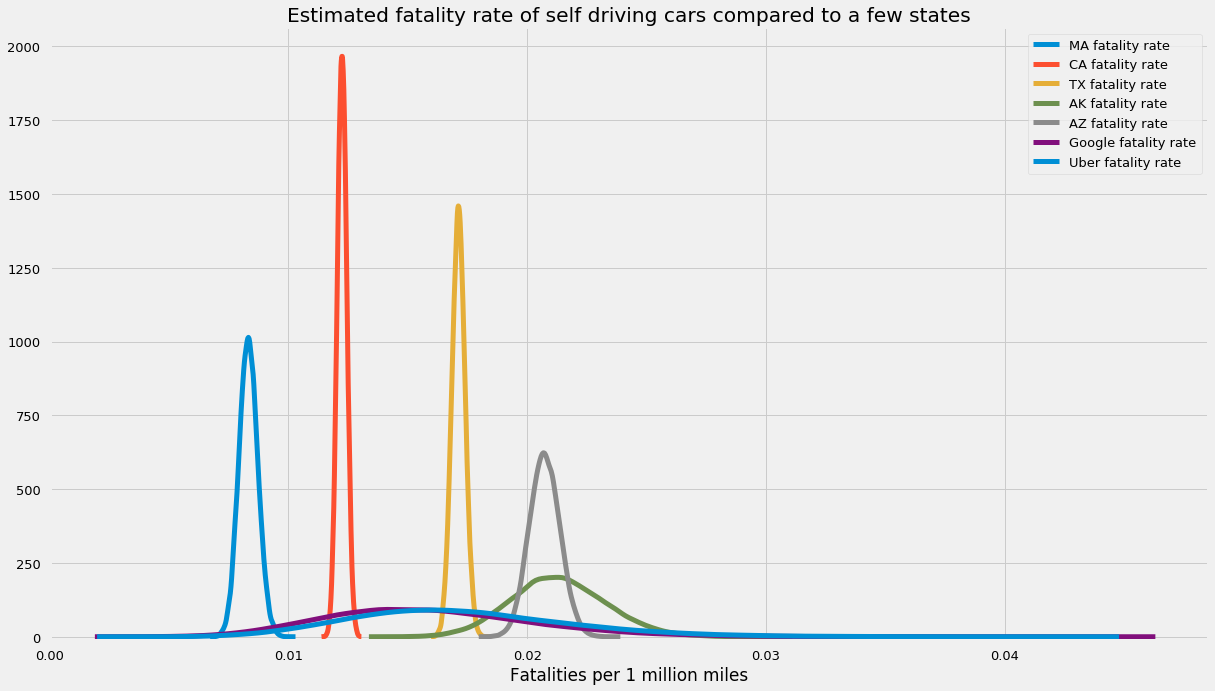

In [19]:
fig, ax = plt.subplots(1, 1)
shared_kwargs = {'hist': False, 'ax': ax, 'kde_kws': {'linewidth': 5}}
for state in ('MA', 'CA', 'TX', 'AK', 'AZ' ):
    sns.distplot(trace['state_rate'][:, df.State == state], label='{} fatality rate'.format(state), **shared_kwargs)
sns.distplot(trace['google_rate'], label='Google fatality rate', **shared_kwargs)
sns.distplot(trace['uber_rate'], label='Uber fatality rate', **shared_kwargs)
fig.set_size_inches(18.5, 10.5)
ax.set_xlim(xmin=0)
ax.set_ylim(ymin=-10)
ax.set_title('Estimated fatality rate of self driving cars compared to a few states')
ax.set_xlabel('Fatalities per 1 million miles')

ax.legend();

You can see that for both Uber and Google the uncertainty interval is very wide for fatality rate. We don't have the data yet to clarify whether or not these cars are safe or not. 
A million miles sounds impressive but it's nowhere near the order of magnitude of what human drivers do each year in any states. 

# Update!

As of November 28, 2017, <a href="https://www.theverge.com/2017/11/28/16709104/waymo-self-driving-autonomous-cars-public-roads-milestone">The Verge</a> reports that Waymo has driven 4 million miles.  How does that change our conclusions?  Not much!  This is reasonable, since the average state has 50 billion miles in the dataset, so moving from 1.5million to 4million should not change the inference very much.

According to <a href="https://www.nytimes.com/2018/03/23/technology/uber-self-driving-cars-arizona.html">The NYT</a> Uber actually did 3 million miles by the time of the accident. We'll change this one too. 

In [14]:
with car_model(miles_e6, fatalities, google_miles=4., uber_miles=3.):
    updated_trace = pm.sample(10000, njobs=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [uber_rate, google_rate, state_rate, κ_log, pooled_rate]
100%|██████████| 10500/10500 [00:27<00:00, 376.69it/s]


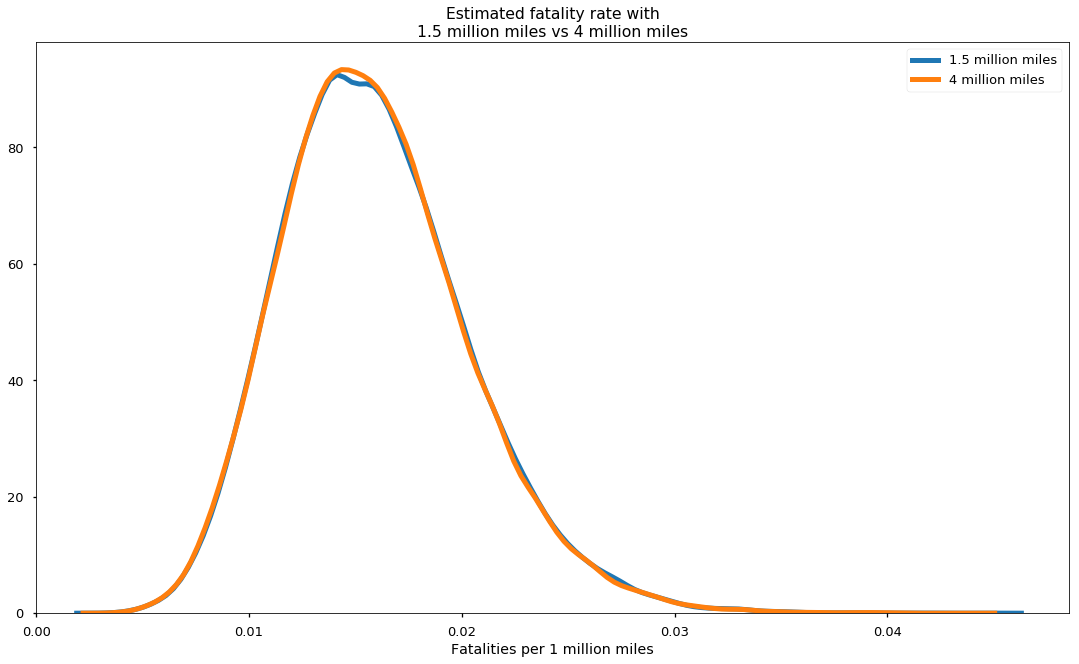

In [15]:
plt.style.use('seaborn-talk')
fig, ax = plt.subplots(1, 1)
shared_kwargs = {'hist': False, 'ax': ax, 'kde_kws': {'linewidth': 5}}
sns.distplot(trace['google_rate'], label='1.5 million miles', **shared_kwargs)
sns.distplot(updated_trace['google_rate'], label='4 million miles', **shared_kwargs)
fig.set_size_inches(18.5, 10.5)
ax.set_xlim(xmin=0)
ax.set_title('Estimated fatality rate with\n1.5 million miles vs 4 million miles')
ax.set_xlabel('Fatalities per 1 million miles')
ax.legend();

# Estimates of fatality rates in all 50 states, plus DC

These are interesting on their own, and I thought I would include it.

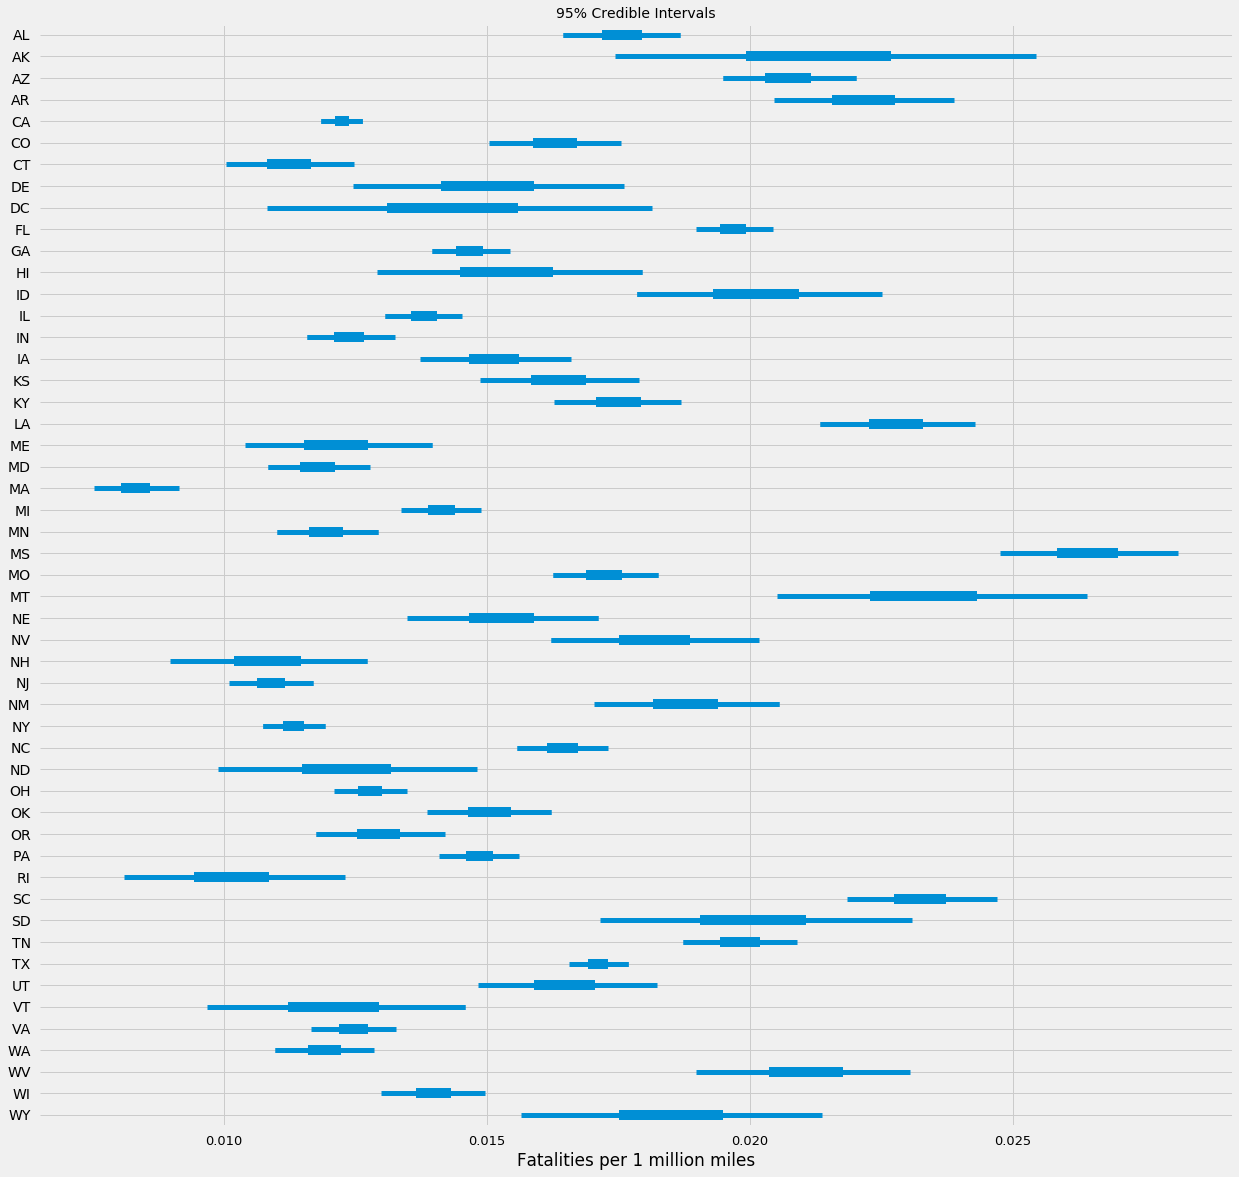

In [24]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (18, 18)
plt.style.use('fivethirtyeight')
pm.forestplot(trace, varnames=('state_rate',), 
              chain_spacing=0, 
              ylabels=df.State, 
              rhat=False, 
              xtitle="Fatalities per 1 million miles",
             plot_kwargs={"linewidth": 10, 'colour': 'purple'});

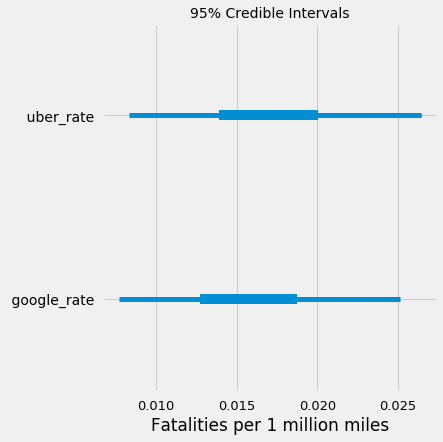

In [22]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (6, 6)
plt.style.use('fivethirtyeight')
pm.forestplot(trace, varnames=('uber_rate', 'google_rate'), 
              chain_spacing=0,               rhat=False, 
              xtitle="Fatalities per 1 million miles",
             plot_kwargs={"linewidth": 10, 'color': 'green'});

## Results
We can see above that the uncertainty intervals of Uber and Google are very wide. 

We hope this is very illustrative of the power of Bayesian modelling. We've been able to model states, Google and Uber (some of which have different amounts of data) and draw reasonable inferences about them. 